In [1]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import cv2
import math
import wandb

data_wd = Path('/data') / 'raspi_face_detection'
img_path = data_wd / 'images'
labels_path = data_wd / 'labels'

model_sets_path = data_wd / 'model_sets'
aug_sets_path = data_wd / 'aug_data'

# 1 Weights & Biases Configuration

In [2]:
run = wandb.init(
    # set the wandb project where this run will be logged
    project='raspi-facial-recognition',

    # track hyperparameters and run metadata
    config={
        'learning_rate': 0.0001,
        'image_cnt': len(list(img_path.glob('*'))),
        'epochs': 20,
        'batch_size': 128,
        'lr_decay_divider': 0.55,
        'dropout_rate': 0.2,
        'classloss_weight': 0.1,
    }
)

config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: brendanfitz (fitzai). Use `wandb login --relogin` to force relogin


### 2.2 Limit GPU Memory Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2024-05-09 12:31:38.979510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-09 12:31:38.986115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-09 12:31:38.986412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 5.2 Load Augmented Images to Tensorflow Dataset

In [5]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [6]:
train_images = tf.data.Dataset.list_files(str(aug_sets_path / 'train' / 'images'/ '*.jpg'), shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

2024-05-09 12:31:39.948421: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-09 12:31:39.950626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-09 12:31:39.950866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-09 12:31:39.951029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [7]:
test_images = tf.data.Dataset.list_files(str(aug_sets_path / 'test' / 'images'/ '*.jpg'), shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [8]:
val_images = tf.data.Dataset.list_files(str(aug_sets_path / 'val' / 'images'/ '*.jpg'), shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [9]:
train_images.as_numpy_iterator().next()

array([[[0.972549  , 0.92941177, 0.99607843],
        [0.978125  , 0.93645835, 0.99871325],
        [0.972549  , 0.9411765 , 1.        ],
        ...,
        [0.84313726, 0.8784314 , 0.90588236],
        [0.8464461 , 0.8745098 , 0.905576  ],
        [0.84705883, 0.8745098 , 0.90588236]],

       [[0.972549  , 0.9377451 , 1.        ],
        [0.97297794, 0.9416054 , 1.        ],
        [0.9759804 , 0.94460785, 1.        ],
        ...,
        [0.85490197, 0.88235295, 0.90588236],
        [0.85588235, 0.88235295, 0.90588236],
        [0.85490197, 0.87941176, 0.9078431 ]],

       [[0.972549  , 0.9411765 , 1.        ],
        [0.972549  , 0.9411765 , 1.        ],
        [0.972549  , 0.9411765 , 1.        ],
        ...,
        [0.86580884, 0.8862745 , 0.9098039 ],
        [0.8666667 , 0.8862745 , 0.9098039 ],
        [0.8507966 , 0.8844975 , 0.90833336]],

       ...,

       [[0.54540443, 0.51893383, 0.46550244],
        [0.5278799 , 0.4886642 , 0.44944853],
        [0.55625   , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [17]:
import itertools

In [18]:
# fn = '49e246c6-0968-11ef-b027-dca632a68397_5.json' # both
# fn = '3a38b642-0968-11ef-b027-dca632a68397_4.json' # kara
# fn = '4a2f0b44-0965-11ef-a3f3-dca632a68397_37.json' # brendan
fn = '369aab30-0968-11ef-b027-dca632a68397_0.json' # error
label_path = aug_sets_path / 'train' / 'labels' / fn
with open(label_path, 'r', encoding = "utf-8") as f:
    label = json.load(f)

label['classes'], label['bboxes']

([2],
 [[0, 0, 0, 0],
  [0.4233247200689061,
   0.24487510766580536,
   0.6584668389319552,
   0.5084409991386737]])

In [19]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [int(x in label['classes']) for x in range(1, 3)], list(itertools.chain(*label['bboxes']))

# classes, bboxes = load_labels(label_path)

### 6.2 Load Labels to Tensorflow Dataset

In [20]:
train_labels = tf.data.Dataset.list_files(str(aug_sets_path / 'train' / 'labels'/ '*.json'), shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [21]:
test_labels = tf.data.Dataset.list_files(str(aug_sets_path / 'test' / 'labels'/ '*.json'), shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [22]:
val_labels = tf.data.Dataset.list_files(str(aug_sets_path / 'val' / 'labels'/ '*.json'), shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [23]:
train_labels.as_numpy_iterator().next()

(array([1, 0], dtype=uint8),
 array([0.3794, 0.    , 0.7188, 0.4138, 0.    , 0.    , 0.    , 0.    ],
       dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [24]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(8220, 8220, 2160, 2160, 2400, 2400)

### 7.2 Create Final Datasets (Images/Labels)

In [25]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(len(train_images))
train = train.batch(config.batch_size)
train = train.prefetch(4)

In [26]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(len(test_images))
test = test.batch(config.batch_size)
test = test.prefetch(4)

In [27]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(len(val_images))
val = val.batch(config.batch_size)
val = val.prefetch(4)

### 7.3 View Images and Annotations

In [28]:
data_samples = train.as_numpy_iterator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


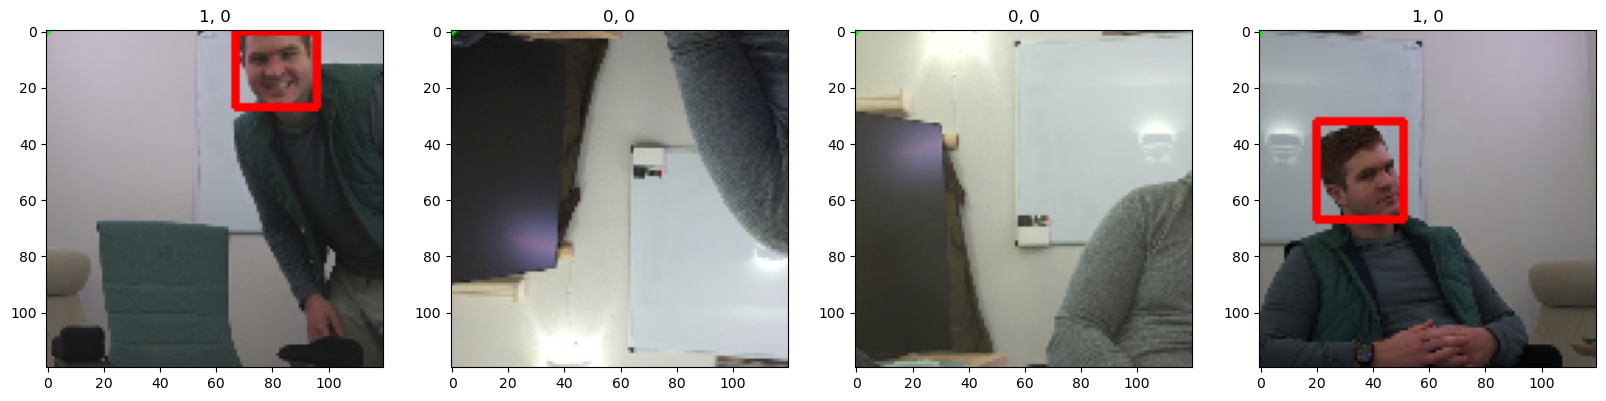

In [29]:
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    sample_labels = ', '.join(res[1][0][idx].astype(str).tolist())

    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[0:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:4], [120,120]).astype(int)), (255,0,0), 2)
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[4:6], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[6:8], [120,120]).astype(int)), (0,255,0), 2)

    ax[idx].imshow(sample_image)
    ax[idx].set_title(sample_labels)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D, Dropout
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [31]:
vgg = VGG16(include_top=False)

In [32]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [33]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class1 = tf.keras.layers.Dropout(config.dropout_rate)(class1)
    class2 = Dense(2, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress1 = Dropout(config.dropout_rate)(regress1)
    regress2 = Dense(8, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [34]:
facetracker = build_model()

In [35]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [36]:
X, y = train.as_numpy_iterator().next()

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [37]:
batches_per_epoch = len(train)
lr_decay = (1./config.lr_decay_divider -1)/batches_per_epoch
lr_decay

0.012587412587412587

In [38]:
opt = tf.keras.optimizers.Adam(learning_rate=config.learning_rate, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [39]:
def localization_loss(y_true, yhat):
    # differences between coordinates
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2])) + tf.reduce_sum(tf.square(y_true[:,4:6] - yhat[:,4:6]))

    # differences between size
    delta_size = 0
    for i in range(2):
        h_true = y_true[:,3+4*i] - y_true[:,1+4*i] 
        w_true = y_true[:,2+4*i] - y_true[:,0+4*i] 
    
        h_pred = yhat[:,3+4*i] - yhat[:,1+4*i] 
        w_pred = yhat[:,2+4*i] - yhat[:,0+4*i] 
        
        delta_size += tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [40]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [41]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+config.classloss_weight*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+config.classloss_weight*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

model = FaceTracker(facetracker)

model.compile(opt, classloss, regressloss)

### 10.2 Train

In [42]:
logdir='logs'

In [43]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [45]:
hist = model.fit(train, epochs=config.epochs, validation_data=val, 
                 callbacks=[tensorboard_callback, wandb.keras.WandbMetricsLogger()])

run.finish()

Epoch 1/20


2024-05-09 12:36:06.988144: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8902
2024-05-09 12:36:07.055991: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-09 12:36:07.056311: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-09 12:36:07.056326: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-05-09 12:36:07.056760: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-09 12:36:07.056788: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-09 12:36:08.532554: I tensorflow/stream_executor/cuda/c

65/65 [==============================] - 21s 188ms/step - total_loss: 28.0703 - class_loss: 0.3555 - regress_loss: 28.0347 - val_total_loss: 6.5590 - val_class_loss: 0.1524 - val_regress_loss: 6.5437
Epoch 2/20
65/65 [==============================] - 12s 145ms/step - total_loss: 8.0280 - class_loss: 0.0834 - regress_loss: 8.0197 - val_total_loss: 3.3490 - val_class_loss: 0.0530 - val_regress_loss: 3.3437
Epoch 3/20
65/65 [==============================] - 12s 145ms/step - total_loss: 5.2215 - class_loss: 0.0484 - regress_loss: 5.2166 - val_total_loss: 2.4750 - val_class_loss: 0.0433 - val_regress_loss: 2.4707
Epoch 4/20
65/65 [==============================] - 12s 145ms/step - total_loss: 3.9771 - class_loss: 0.0335 - regress_loss: 3.9738 - val_total_loss: 4.3882 - val_class_loss: 0.0754 - val_regress_loss: 4.3806
Epoch 5/20
65/65 [==============================] - 12s 145ms/step - total_loss: 3.3288 - class_loss: 0.0251 - regress_loss: 3.3263 - val_total_loss: 2.0006 - val_class_loss

epoch/class_loss,█▆▂▂▂▃▂▂▁▁▂▁▂▂▁▂▁▃▁▁
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/regress_loss,█▆▄▂▃▃▂▂▂▁▂▁▂▁▁▃▁▂▁▂
epoch/total_loss,█▆▄▂▃▃▂▂▂▁▂▁▂▁▁▃▁▂▁▂
epoch/val_class_loss,█▃▃▄▃▄▂▂▃▁▂▁▂▁▁▂▁▂▁▂
epoch/val_regress_loss,█▄▃▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂
epoch/val_total_loss,█▄▃▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂
epoch/class_loss,0.00467
epoch/epoch,19
epoch/learning_rate,0.001


### 10.3 Plot Performance

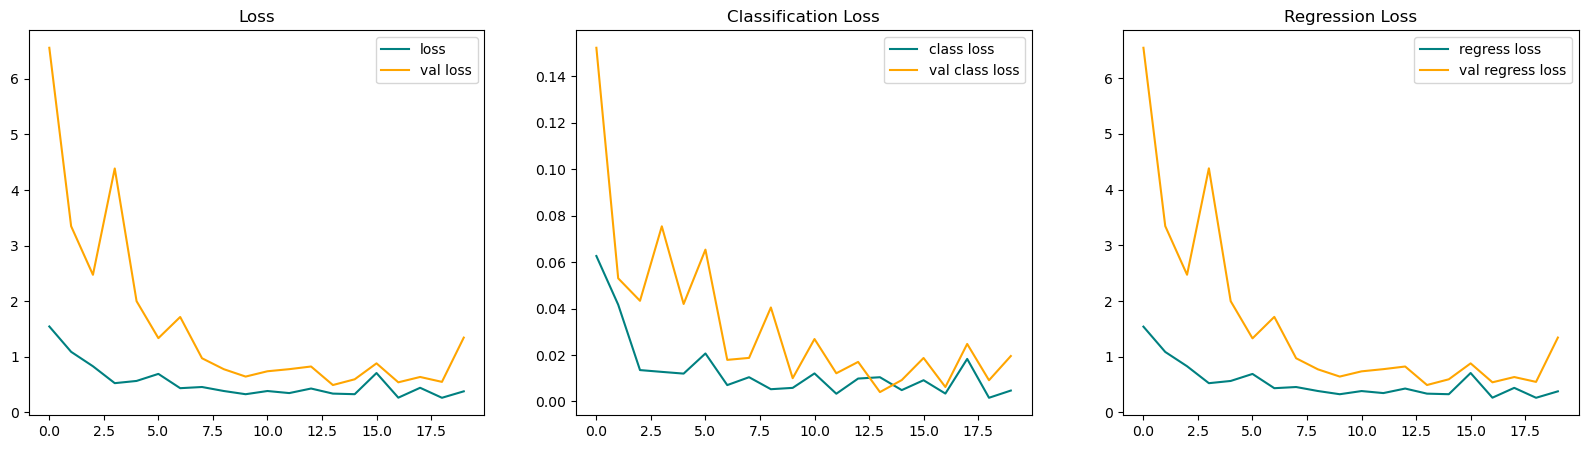

In [46]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [47]:
test_data = test.as_numpy_iterator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


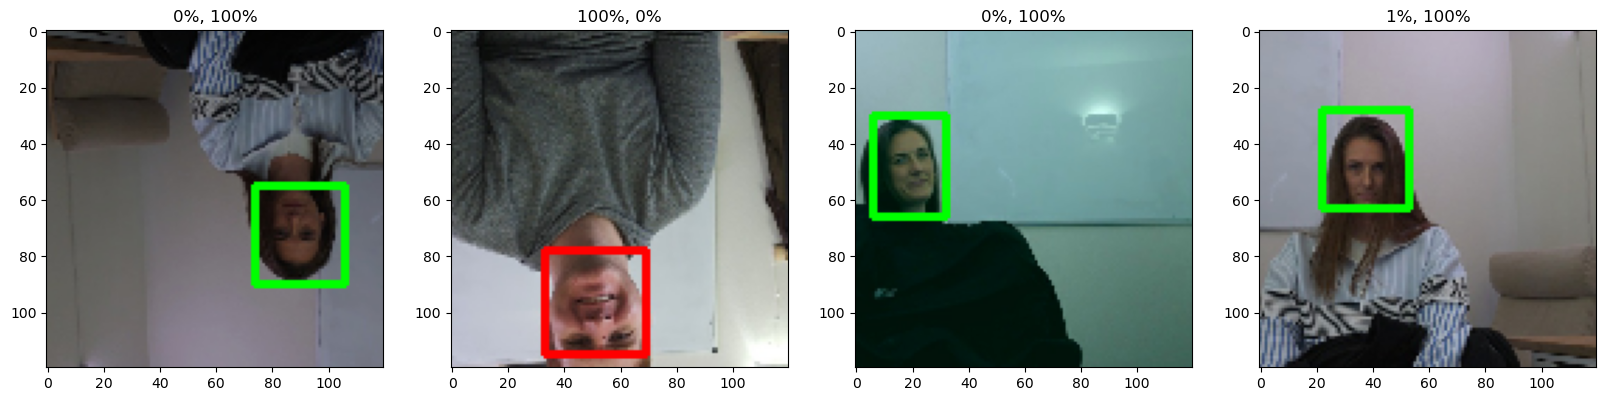

In [48]:
test_sample = test_data.next()

yhat = facetracker.predict(test_sample[0])

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx][0] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[0:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:4], [120,120]).astype(int)), (255,0,0), 2)
    if yhat[0][idx][1] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[4:6], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[6:8], [120,120]).astype(int)), (0,255,0), 2)
    
    ax[idx].imshow(sample_image)
    ax[idx].set_title(', '.join([f'{x:,.0%}' for x in yhat[0][idx]]))

### 11.2 Save the Model

In [49]:
facetracker.save('facetracker.h5')